In [115]:
import common_utils
from common_utils import *
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

setup_seed()
device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [116]:
#!rm -rf ./fm_conditional_checkpoints

Parsed 55 category labels and 94 ids from EMOJI_FACE/labels.json
Found 55 flattened categories:
  0: emotion_fx:clouds
  1: emotion_fx:drool
  2: emotion_fx:exploding_head
  3: emotion_fx:nose_grow
  4: emotion_fx:shivering_ice
  5: emotion_fx:sneezing
  6: emotion_fx:steam_nose
  7: emotion_fx:sweat_drop
  8: emotion_fx:tears_joy
  9: emotion_fx:tears_sad
  10: emotion_fx:zzz_sleeping
  11: eye_accessory:glasses_disguise
  12: eye_accessory:glasses_monocle
  13: eye_accessory:glasses_nerd
  14: eye_accessory:glasses_sunglasses
  15: eye_accessory:hearts
  16: eye_accessory:money_sign
  17: eye_accessory:stars
  18: eye_shape:closed_flat_down
  19: eye_shape:dead_spiral_cross
  20: eye_shape:looking_side
  21: eye_shape:neutral_dots
  22: eye_shape:raised_eyebrow
  23: eye_shape:rolling_up
  24: eye_shape:smiling_curve
  25: eye_shape:tight_closed_X
  26: eye_shape:wide_open_shock
  27: eye_shape:winking
  28: eye_shape:zany_uneven
  29: facial_hair_hat:bandage_head
  30: facial_hair_h

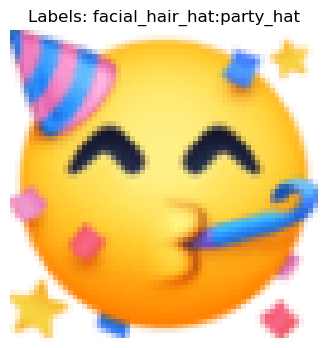

In [117]:
# Load Labels and Mappings
label_path = 'EMOJI_FACE/labels.json'
categories, cat_to_idx, idx_to_cat, folder_to_cats = load_labels_and_mappings(labels_path=label_path)

print(f"Found {len(categories)} flattened categories:")
for i, cat in idx_to_cat.items():
    print(f"  {i}: {cat}")

# Initialize Data
data = load_conditional_dataset(root_dir="./EMOJI_FACE", folder_to_cats=folder_to_cats, num_categories=len(categories))
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

# Show a sample
img, label_vec = next(iter(dataloader))
plt.figure(figsize=(4,4))
show_tensor_image(img[0])
active = (label_vec[0] > 0).nonzero(as_tuple=True)[0].tolist()
active_names = ", ".join(idx_to_cat[i] for i in active)
plt.title(f"Labels: {active_names}")
plt.show()

In [118]:
model = ConditionalUnet(num_classes=len(categories))
# print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

ConditionalUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (class_emb): Embedding(55, 128)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ResnetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adagn1): AdaGroupNorm(
        (group_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (time_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (relu): SiLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adagn2): AdaGroupNorm(
        (group_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (time_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (skip_connection): Identity()
    )
    (1): Conv2d(64, 128, kernel_size=(4, 4)

## Loss Function

The loss function now takes `labels` and passes them to the model.

In [ ]:
def get_loss(model, x_1, t, labels_vec, device="cpu", cond_dropout=0.1):
    # Linear FM target
    x_0 = torch.randn_like(x_1)
    t_reshaped = t.view(-1, 1, 1, 1)
    x_t = (1 - t_reshaped) * x_0 + t_reshaped * x_1
    target_v = x_1 - x_0

    # Classifier-Free Guidance dropout: randomly drop labels to zeros
    if cond_dropout and cond_dropout > 0:
        drop_mask = (torch.rand(labels_vec.shape[0], device=device) < cond_dropout).float().view(-1, 1)
        labels_in = labels_vec.to(device) * (1.0 - drop_mask)
    else:
        labels_in = labels_vec.to(device)

    # Forward with multi-hot labels
    pred_v = model(x_t, t * 1000, labels_in)

    return F.mse_loss(pred_v, target_v) # better
    # return F.l1_loss(pred_v, target_v)

## Sampling

We update the sampling function to accept a `class_label`.

In [120]:
@torch.no_grad()
def build_label_vec_for_id(target_id, num_categories, folder_to_cats):
    # target_id can be int or str
    fid = str(target_id)
    vec = torch.zeros((1, num_categories), dtype=torch.float32, device=device)
    indices = folder_to_cats.get(fid, [])
    for ci in indices:
        if 0 <= ci < num_categories:
            vec[0, ci] = 1.0
    return vec

@torch.no_grad()
def sample_ode_euler_cfg(model, label_vec, steps=20, guidance_scale=3.0, device="cpu"):
    img_size = IMG_SIZE
    x = torch.randn((1, 3, img_size, img_size), device=device)
    dt = 1.0 / steps

    traj = [x.clone()]

    for i in range(steps):
        t_val = i / steps
        t = torch.full((1,), t_val, device=device, dtype=torch.float32)

        # Unconditional (zero labels) and conditional predictions
        v_uncond = model(x, t * 1000, torch.zeros_like(label_vec))
        v_cond = model(x, t * 1000, label_vec)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        x = x + v * dt

        if i % (max(steps // 10, 1)) == 0:
            traj.append(x.clone())

    return x, traj

@torch.no_grad()
def sample_plot_conditional_by_id(target_id=None, steps=50, guidance_scale=3.0, save_path=None):
    # Pick random id if not provided
    if target_id is None:
        if len(folder_to_cats) == 0:
            raise ValueError("folder_to_cats is empty; ensure labels.json parsed correctly.")
        target_id = random.choice(list(folder_to_cats.keys()))
    fid = str(target_id)
    print(f"Generating sample for id: {fid}")

    label_vec = build_label_vec_for_id(fid, len(categories), folder_to_cats)

    plt.figure(figsize=(15, 3))
    plt.axis('off')

    final_img, traj = sample_ode_euler_cfg(model, label_vec, steps=steps, guidance_scale=guidance_scale, device=device)

    num_plots = 10
    step_size = max(len(traj) // num_plots, 1)

    for i in range(num_plots):
        idx = i * step_size
        if idx >= len(traj):
            break
        plt.subplot(1, num_plots + 1, i + 1)
        show_tensor_image(traj[idx].detach().cpu())

    plt.subplot(1, num_plots + 1, num_plots + 1)
    show_tensor_image(final_img.detach().cpu())
    plt.subplots_adjust(wspace=0.0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## Training Loop

In [121]:
from torch.optim import AdamW
import time
import csv
import pandas as pd

optimizer = AdamW(model.parameters(), lr=2e-4)
epochs = 1900

checkpoint_dir = "fm_conditional_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
log_file = os.path.join(checkpoint_dir, "train_log.csv")
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")

start_epoch = 0
best_loss = float("inf")

# Resume logic
if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
    try:
        log_df = pd.read_csv(log_file)
        if not log_df.empty:
            last_epoch = log_df['epoch'].iloc[-1]
            start_epoch = int(last_epoch) + 1
            print(f"Resuming from epoch {start_epoch}")
    except:
        pass

if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint.get('loss', float('inf'))

if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "avg_loss", "duration_sec"])

pending_rows = []
flush_every = 10

for epoch in range(start_epoch, epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.perf_counter()
    
    for step, (images, labels_vec) in enumerate(dataloader):
        optimizer.zero_grad()
        
        x_1 = images.to(device)
        labels_vec = labels_vec.to(device)
        
        current_batch_size = x_1.shape[0]
        t = torch.rand(current_batch_size, device=device)
        
        loss = get_loss(model, x_1, t, labels_vec, device=device, cond_dropout=0.1)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    duration = time.perf_counter() - start_time
    
    pending_rows.append([epoch, avg_epoch_loss, duration])

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_model_path)
        print(f"New best model saved! Epoch:{epoch} Loss: {best_loss:.4f}")
        
        # Visualize progress
        model.eval()
        save_path = os.path.join(checkpoint_dir, f"epoch{epoch}_loss{best_loss:.4f}.png")
        sample_plot_conditional_by_id(steps=50, guidance_scale=3.0, save_path=save_path)

    if (len(pending_rows) >= flush_every) or (epoch == epochs - 1):
        with open(log_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(pending_rows)
        pending_rows.clear()

Resuming from epoch 1900
Loading best model from fm_conditional_checkpoints/best_model.pt


Generating sample for id: 7


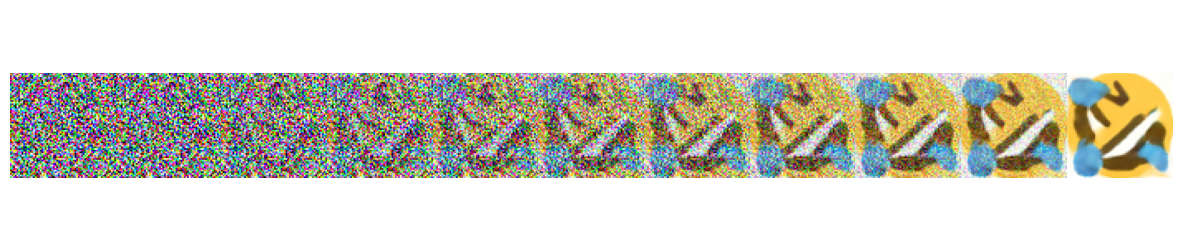

In [122]:
# Generate samples for a few ids
model.eval()
random_id = random.choice(list(folder_to_cats.keys()))
sample_plot_conditional_by_id(random_id, steps=50, guidance_scale=3.0)

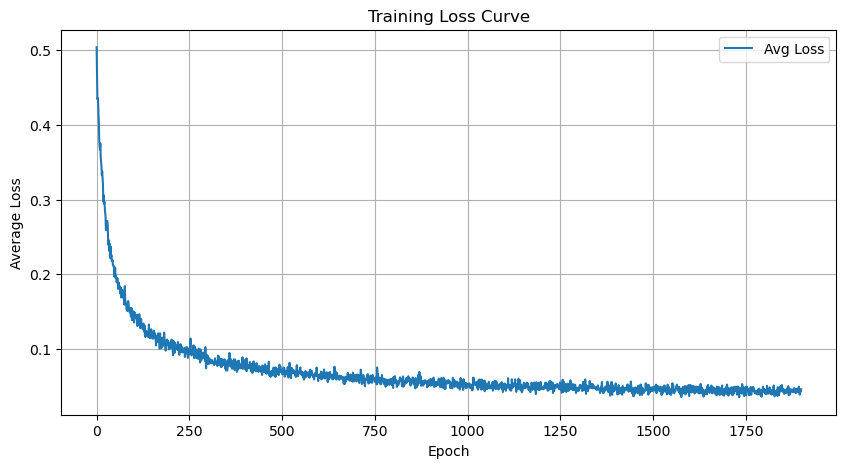

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取日志
df = pd.read_csv(checkpoint_dir + "/train_log.csv")

# 绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['avg_loss'], label='Avg Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

#### 针对每个风格生成图片

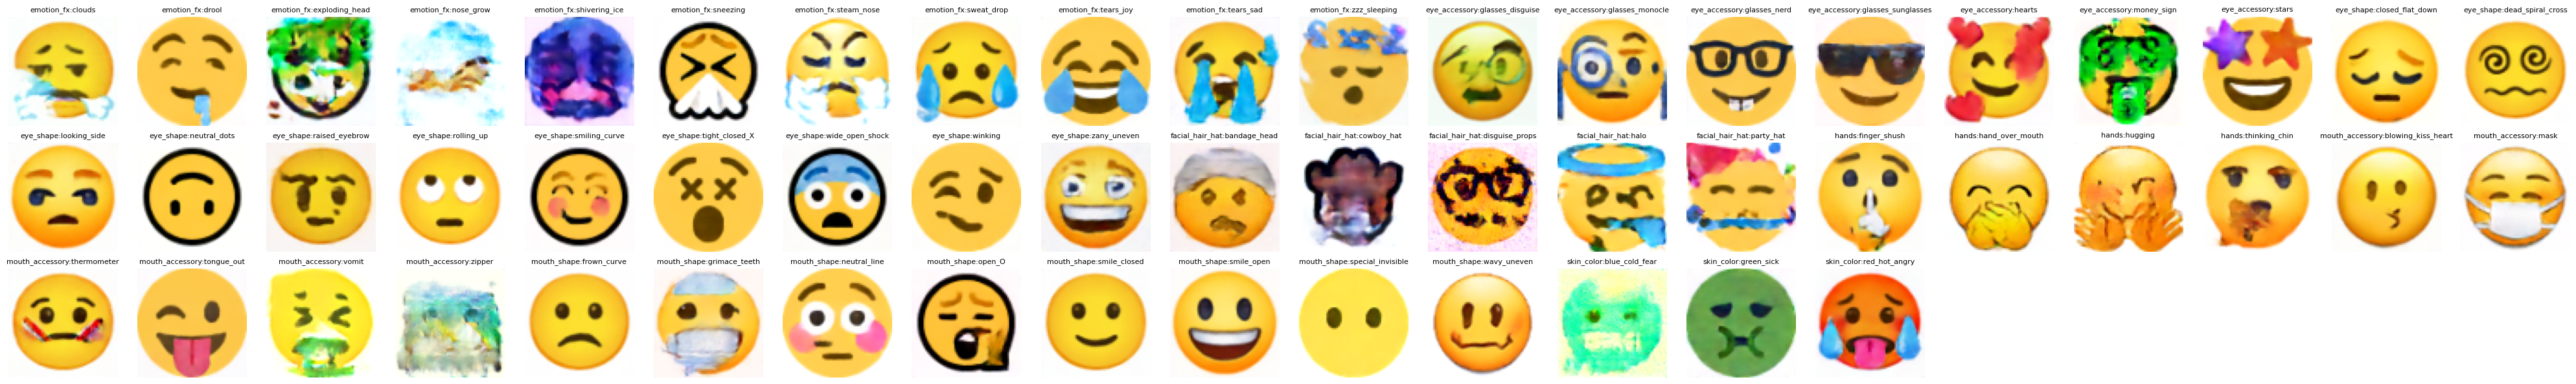

In [129]:
# Procedural: generate one final image per flattened category and stitch into a grid
# Adjust these parameters as needed
max_categories = len(categories)  # set to an int to limit, or None to use all (will be capped)
COLS = 20
STEPS = 50
GUIDANCE = 3.0

import math

imgs = []
for idx in range(max_categories):
    # single-label multi-hot vector for this flattened category
    label_vec = torch.zeros((1, len(categories)), dtype=torch.float32, device=device)
    label_vec[0, idx] = 1.0

    # generate final image only
    final_img, _ = sample_ode_euler_cfg(model, label_vec, steps=STEPS, guidance_scale=GUIDANCE, device=device)

    # convert to numpy uint8 HWC
    t = final_img.detach().cpu().squeeze(0)
    t = (t + 1.0) / 2.0
    t = t.clamp(0, 1)
    arr = (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    imgs.append(arr)

# Stitch and display
rows = math.ceil(max_categories / COLS)
plt.figure(figsize=(COLS * 2, rows * 2))
for i, arr in enumerate(imgs):
    plt.subplot(rows, COLS, i + 1)
    plt.imshow(arr)
    plt.axis('off')
    plt.title(idx_to_cat[i], fontsize=8)
plt.tight_layout()
plt.show()


#### 针对每个图片id检验生成效果

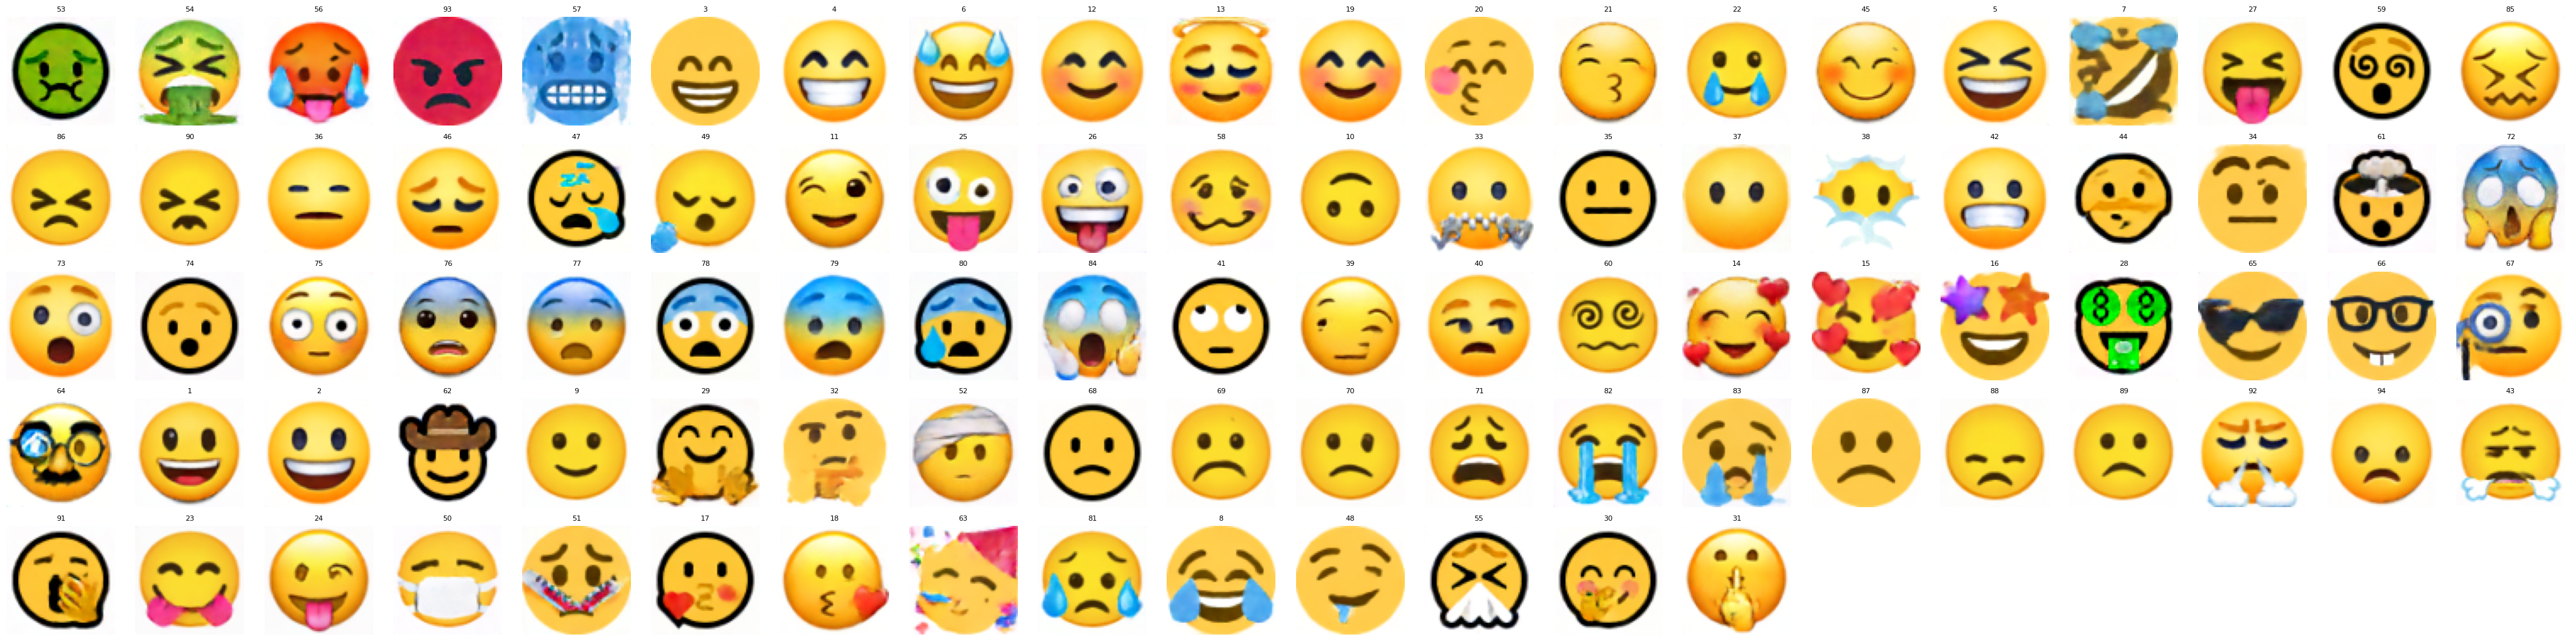

In [131]:
# 说明：依赖已定义的变量/函数：model, categories, folder_to_cats, device, sample_ode_euler_cfg, build_label_vec_for_id
COLS = 20         # 每行显示多少图
STEPS = 50      # 采样步数
GUIDANCE = 3.0   # classifier-free guidance 强度

# 计算实际要生成的id数（应用安全上限）
max_ids = len(folder_to_cats)

imgs = []
titles = []
ids_list = list(folder_to_cats.keys())[:max_ids]

# 逐id生成最终图像（只获取最终结果，不显示中间过程）
for fid in ids_list:
    # 构建该id对应的label向量
    label_vec = build_label_vec_for_id(fid, len(categories), folder_to_cats)

    # 生成最终图（返回 final_img, traj；只用 final_img）
    final_img, _ = sample_ode_euler_cfg(model, label_vec, steps=STEPS, guidance_scale=GUIDANCE, device=device)

    # 转为 HWC uint8 numpy，值域 [0,255]
    t = final_img.detach().cpu().squeeze(0)        # CHW in [-1,1]
    t = (t + 1.0) / 2.0
    t = t.clamp(0, 1)
    arr = (t.permute(1, 2, 0).numpy() * 255).astype("uint8")

    imgs.append(arr)
    titles.append(fid)

# 拼接并显示网格
rows = math.ceil(len(imgs) / COLS)
fig, axes = plt.subplots(rows, COLS, figsize=(COLS * 2, rows * 2))
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(titles[i], fontsize=8)
plt.tight_layout()
plt.show()